<a href="https://colab.research.google.com/github/dormeir999/cities-classifier/blob/master/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & setup

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import requests
import zipfile
import glob
import os
from google.colab import drive
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import tensorflow as tf
from pathlib import Path
import glob
import numpy as np
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
path_model = '/content/gdrive/My Drive/adidas/02-model'
path_data =  '/content/gdrive/My Drive/adidas/01-data'
os.listdir(path_model) # test

['.ipynb_checkpoints',
 'weights',
 'logs',
 'model',
 'LeNet-Model',
 'tf image classification.ipynb',
 'tf image classification - Dor.ipynb',
 'Daniel Research Log.gdoc',
 'GAN',
 'MobileNet-19cities-ACC90.h5',
 'inceptionsV3_19cities.h5',
 'inceptionsV3_19cities_at.h5',
 'efficient_model.h5',
 'mob_model.h5']

In [ ]:
# colab output:
output_folder_path = '.'
output_folder_path = Path(output_folder_path)

# Load Data


In [ ]:
# get list of links from aws
map_links = pd.read_csv(
    'https://ww-research.s3-us-west-2.amazonaws.com/Arad/adidas/mapillary_links.csv'
    ,header=None).iloc[:,0].to_list()

In [ ]:
def download_url(url, save_path=False, chunk_size=128):
    "downloads zip files to the folder that the notebook / python file is saved"
    if not save_path:
        save_path = url.split('/')[-1]

    with requests.get(url, stream=True) as r:
        with open(save_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)
    print(f"file {save_path} succesfuly downloaded")

    
def unzip_to_structure(zipfile_path, output_root_folder):
    """unzips files to specified output root folder with structure: 
        <output_root_folder> / <set_type> / <city> / <img_key>.jpg"""
    output_root_folder = Path(output_root_folder)
    file_parts = str(Path(zipfile_path).stem).split('_')
    city = file_parts[0]
    set_type = file_parts[1]
    for s in ['train','test','val']:   
      with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
        if set_type == s:
          zip_ref.extractall(output_root_folder / s )
    print(f"images from '{zipfile_path}' succesfuly unziped to '{output_root_folder / set_type / city}'")


def get_images(cities,output_path=output_folder_path,download_test=False):
  """gets all images for defined cities
  param:: cities, array of cities
  param:: output_path """
  linkz = []
  if not download_test:
    links = [l for l in map_links if 'test' not in l]
  else:
    links = map_links
  for city in cities:
    for link in links:
      if city in link:
        linkz.append(link) 
  # download files to current directory
  for link in linkz:
      download_url(link)
  # unzip images to destination with format: 
  # <output_root_folder> / <set_type> / <city> / <img_key>.jpg
  for link in linkz:
      filename = Path(link).name
      unzip_to_structure(filename,output_path)  

In [ ]:
# get data to current working dir (for changing dir got to top of the notebook):

# available cities:
my_cities = ['saopaulo','moscow','paris','manila','ottawa','austin','bangkok',
 'sf','phoenix','melbourne','tokyo','goa','toronto','berlin', 'budapest',
 'cph','helsinki','boston','amsterdam']

# city selection:
my_cities = ['saopaulo','paris','goa']

# download images from aws:
get_images(my_cities,download_test=True) 

file saopaulo_train.zip succesfuly downloaded
file saopaulo_val.zip succesfuly downloaded
file saopaulo_test.zip succesfuly downloaded
file paris_train.zip succesfuly downloaded
file paris_val.zip succesfuly downloaded
file paris_test.zip succesfuly downloaded
file goa_train.zip succesfuly downloaded
file goa_val.zip succesfuly downloaded
file goa_test.zip succesfuly downloaded
images from 'saopaulo_train.zip' succesfuly unziped to 'train/saopaulo'
images from 'saopaulo_val.zip' succesfuly unziped to 'val/saopaulo'
images from 'saopaulo_test.zip' succesfuly unziped to 'test/saopaulo'
images from 'paris_train.zip' succesfuly unziped to 'train/paris'
images from 'paris_val.zip' succesfuly unziped to 'val/paris'
images from 'paris_test.zip' succesfuly unziped to 'test/paris'
images from 'goa_train.zip' succesfuly unziped to 'train/goa'
images from 'goa_val.zip' succesfuly unziped to 'val/goa'
images from 'goa_test.zip' succesfuly unziped to 'test/goa'


In [ ]:
def get_data_to_numpy(file_list):
    X = []
    for filename in file_list :
        img = img_to_array(load_img(filename, target_size = (150,150)))
        X.append(img)
    X = np.array(X).astype('float32')
    # X = (X - X.mean()) / X.mean()
    X = X / 255
    return X

import glob
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

train_filelist = glob.glob('./train/*/*')
val_filelist = glob.glob('./val/*/*')
test_filelist = glob.glob('./train/*/*')
len(train_filelist), len(val_filelist), len(test_filelist)

#X_train = get_data(train_filelist)
#X_val = get_data(val_filelist)
#X_test = get_data(test_filelist)

(16966, 6516, 16966)

# Image Preprocessing

In [ ]:
import os
import tensorflow as tf
from pathlib import Path
import glob
import numpy as np
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Set image and batch size

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 128

In [ ]:
train_dir = Path("./train")
val_dir = Path("./val")
test_dir = Path("./test")

In [ ]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')])
CLASS_NAMES

array(['goa', 'paris', 'saopaulo'], dtype='<U8')

In [ ]:
train_image_count = len(list(train_dir.glob('*/*.jpg')))
val_image_count = len(list(val_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))
train_image_count,val_image_count,test_image_count

(16966, 6516, 6518)

## Cached processing \ tf.data.Dataset

In [ ]:
list_train = tf.data.Dataset.list_files(str(train_dir/"*/*"))
list_val = tf.data.Dataset.list_files(str(val_dir/"*/*"))
list_test = tf.data.Dataset.list_files(str(test_dir/"*/*"),shuffle=False)

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
# Use Dataset.map to create a dataset of image, label pairs:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_train = list_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_val = list_val.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_test = list_test.map(process_path, num_parallel_calls=AUTOTUNE)

train_dataset = prepare_for_training(labeled_train)
val_dataset = prepare_for_training(labeled_val)
test_dataset = prepare_for_training(labeled_test)

# Build, complie & train

## Initialize InceptionV3

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorboard.plugins.hparams import api as hp

CLASSES = len(CLASS_NAMES)
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False, 
                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)

predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# when you want all of the pre-trained layers to be frozen
# for layer in base_model.layers:
#     layer.trainable = False

# when you want all of the pre-trained layers to be trained
for layer in model.layers:
    layer.trainable = True

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
checkpoint_filepath = path_model + '/weights/InceptionV3.ckpt'
# # model.save(path_model + '/inceptionsV3_19cities.h5')

# model.load_weights(checkpoint_filepath)

In [ ]:
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
VAL_STEPS = np.ceil(val_image_count/BATCH_SIZE)

In [ ]:
EPOCHS = 10

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=3,
                                               verbose=1,
                                               restore_best_weights=True)

model_cp_cb = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True)
    # checkpoint_filepath

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=val_dataset,
                    validation_steps=VAL_STEPS,
                    callbacks=[es_callback])

Epoch 1/10
133/133 [==============================] - 46s 346ms/step - loss: 0.1585 - accuracy: 0.9416 - val_loss: 8.0905 - val_accuracy: 0.6855
Epoch 2/10
133/133 [==============================] - 27s 201ms/step - loss: 0.0496 - accuracy: 0.9842 - val_loss: 0.5378 - val_accuracy: 0.8549
Epoch 3/10
133/133 [==============================] - 27s 201ms/step - loss: 0.0315 - accuracy: 0.9891 - val_loss: 0.3234 - val_accuracy: 0.8995
Epoch 4/10
133/133 [==============================] - 27s 201ms/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.2740 - val_accuracy: 0.9366
Epoch 5/10
133/133 [==============================] - 27s 200ms/step - loss: 0.0186 - accuracy: 0.9942 - val_loss: 0.3951 - val_accuracy: 0.8843
Epoch 6/10
133/133 [==============================] - 27s 200ms/step - loss: 0.0179 - accuracy: 0.9943 - val_loss: 0.2821 - val_accuracy: 0.9174
Epoch 7/10
133/133 [==============================] - 27s 201ms/step - loss: 0.0202 - accuracy: 0.9937 - val_loss: 0.3134 - val_ac

In [ ]:
model.save(path_model + '/inceptionsV3_19cities_at.h5')

# Evaluate model on test set

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
li = list(labeled_test)

In [ ]:
# Get y_true and y_pred
X_true = np.array([l[0].numpy() for l in li])
Y_true = np.array([list(l[1].numpy()) for l in li])
y_true = np.argmax(Y_true,axis=1)
Y_pred = model.predict(np.array(X_true),verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

204/204 [==============================] - 5s 25ms/step


In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Classification Report
              precision    recall  f1-score   support

         goa       0.96      0.99      0.97      2427
       paris       0.98      0.87      0.92      2320
    saopaulo       0.86      0.97      0.91      1771

    accuracy                           0.94      6518
   macro avg       0.94      0.94      0.94      6518
weighted avg       0.94      0.94      0.94      6518



Confusion Matrix


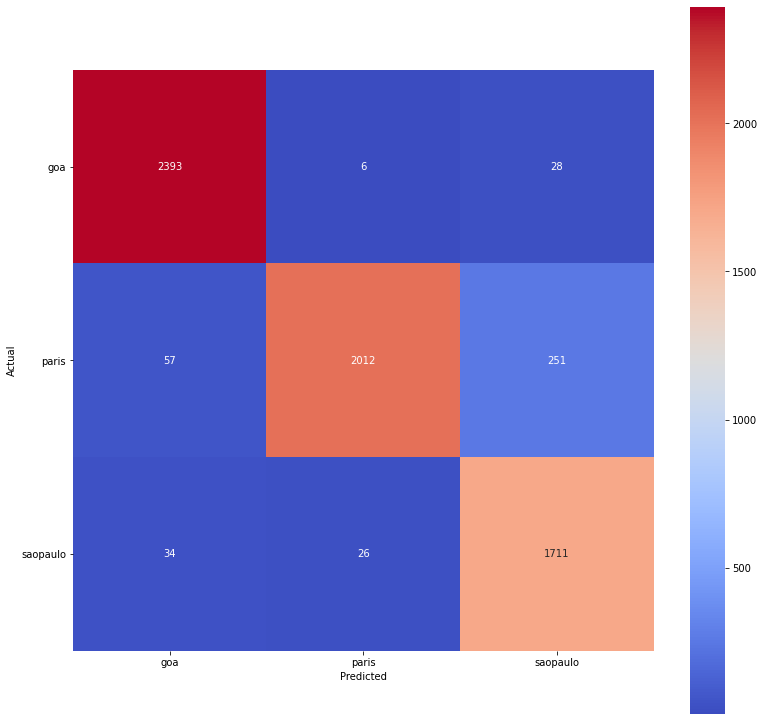

In [ ]:

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, fmt='g',cmap = 'coolwarm',square=True,xticklabels=CLASS_NAMES,yticklabels=CLASS_NAMES)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual');

# Attempt visualize feature map!

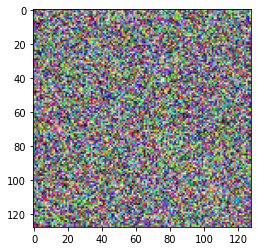

In [ ]:
Z = np.random.random((128,128,3))   # Test data
plt.imshow(Z);

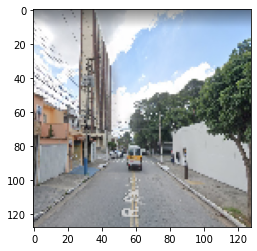

In [ ]:
plt.imshow(np.array(X_true[8]))

In [ ]:
np.array(model.layers[1].get_weights()).shape
model.layers[1].output.shape

TensorShape([None, 63, 63, 32])

In [ ]:
for i, la in enumerate(model.layers):
  if 'conv' in la.name:
    print(i, la.name)

1 conv2d
4 conv2d_1
7 conv2d_2
11 conv2d_3
14 conv2d_4
18 conv2d_8
21 conv2d_6
22 conv2d_9
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
41 conv2d_15
44 conv2d_13
45 conv2d_16
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
64 conv2d_22
67 conv2d_20
68 conv2d_23
74 conv2d_19
75 conv2d_21
76 conv2d_24
77 conv2d_25
87 conv2d_27
90 conv2d_28
93 conv2d_26
94 conv2d_29
101 conv2d_34
104 conv2d_35
107 conv2d_31
108 conv2d_36
113 conv2d_32
114 conv2d_37
120 conv2d_30
121 conv2d_33
122 conv2d_38
123 conv2d_39
133 conv2d_44
136 conv2d_45
139 conv2d_41
140 conv2d_46
145 conv2d_42
146 conv2d_47
152 conv2d_40
153 conv2d_43
154 conv2d_48
155 conv2d_49
165 conv2d_54
168 conv2d_55
171 conv2d_51
172 conv2d_56
177 conv2d_52
178 conv2d_57
184 conv2d_50
185 conv2d_53
186 conv2d_58
187 conv2d_59
197 conv2d_64
200 conv2d_65
203 conv2d_61
204 conv2d_66
209 conv2d_62
210 conv2d_67
216 conv2d_60
217 conv2d_63
218 conv2d_68
219 conv2d_69
229 conv2d_72
232 conv2d_73
235 conv2d_70
236 conv2d_74
241 conv2

In [ ]:
im = np.expand_dims(np.array(X_true[8]), axis=0)

first_conv = Model(inputs=model.inputs, outputs=model.layers[1].output)
feature_maps_fir = first_conv.predict(im)

last_conv = Model(inputs=model.inputs, outputs=model.layers[14].output)
feature_maps_last = last_conv.predict(im)

In [ ]:
# for i in range(32):
#   plt.imshow(feature_maps_fir[0, :, :, i])
#   plt.show()

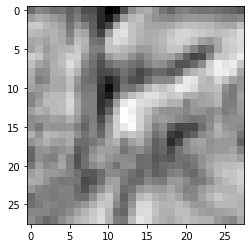

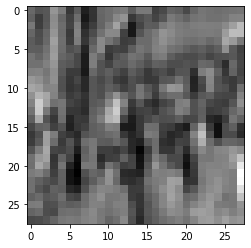

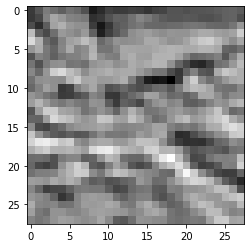

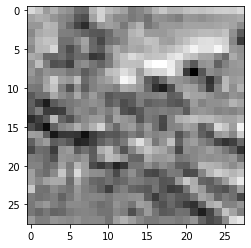

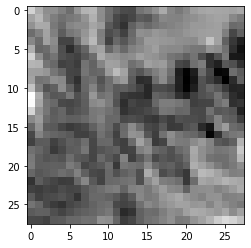

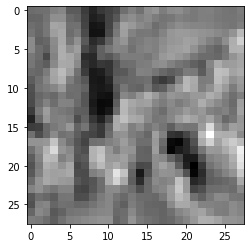

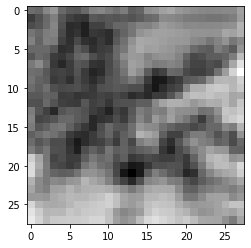

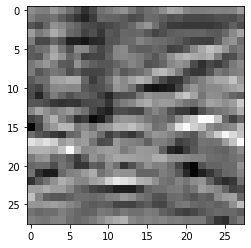

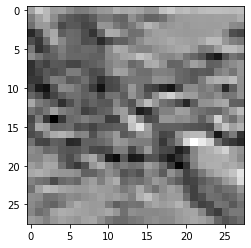

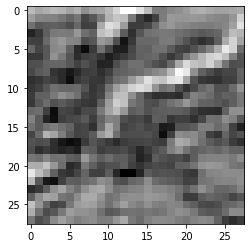

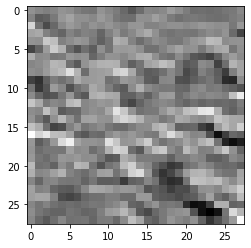

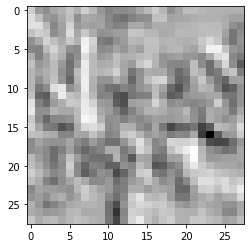

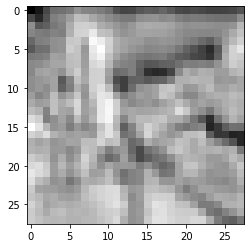

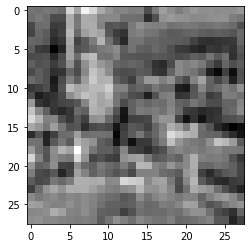

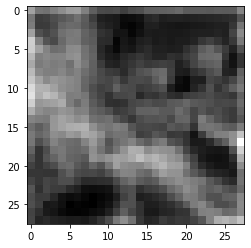

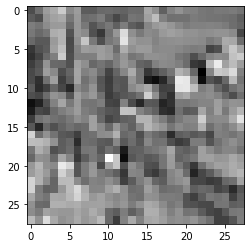

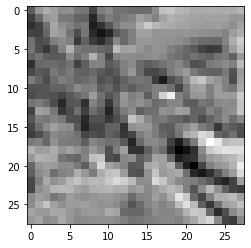

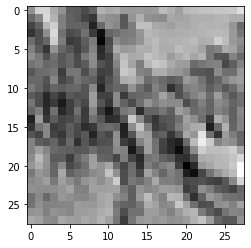

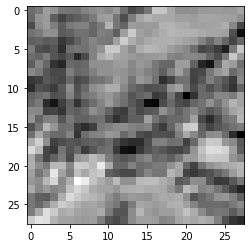

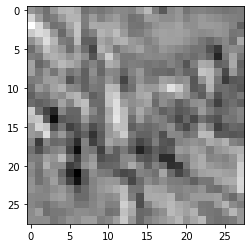

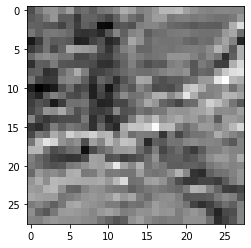

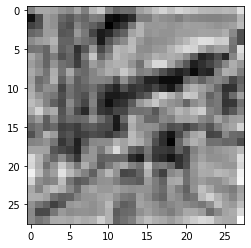

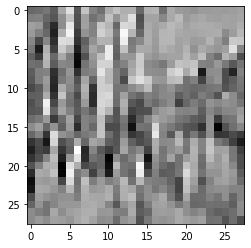

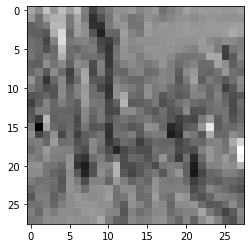

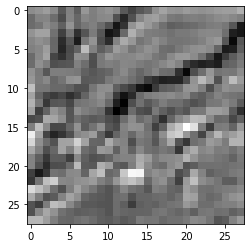

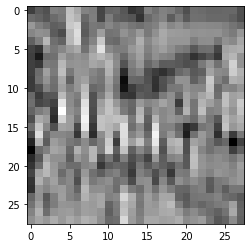

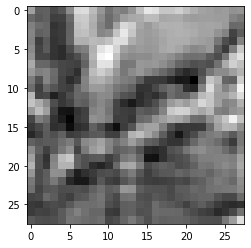

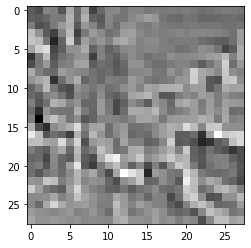

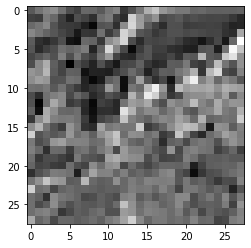

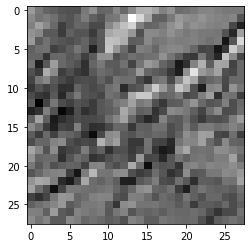

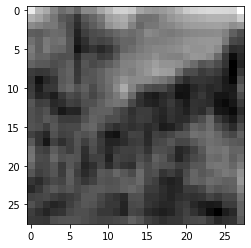

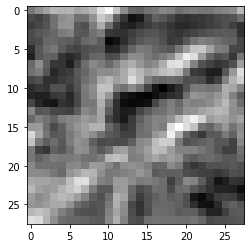

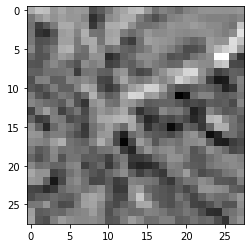

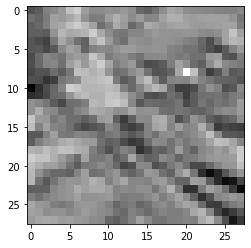

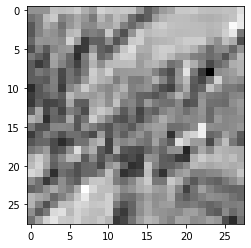

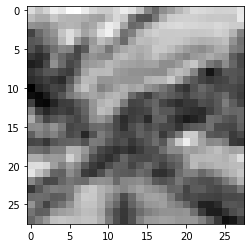

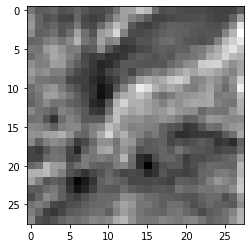

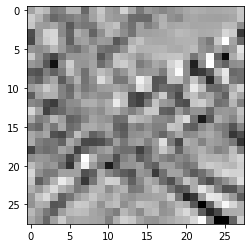

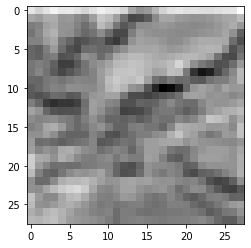

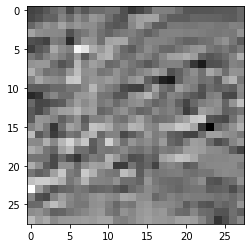

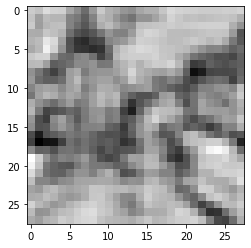

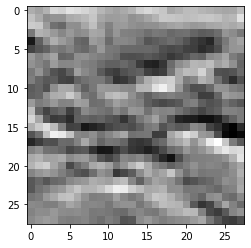

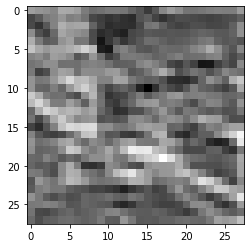

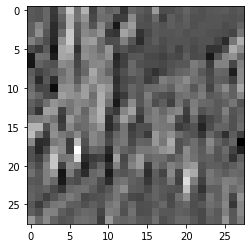

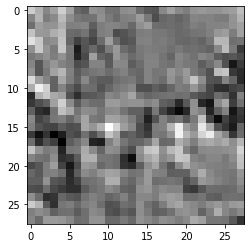

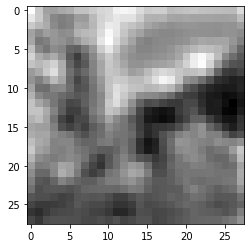

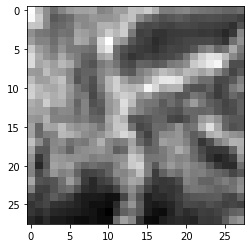

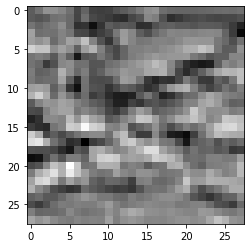

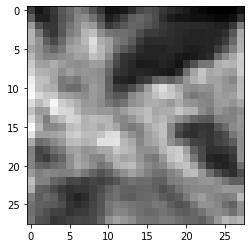

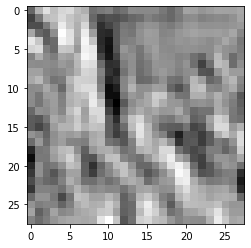

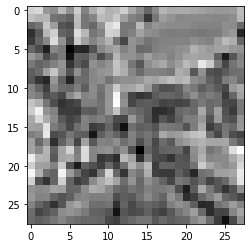

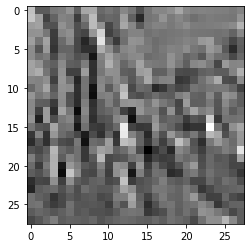

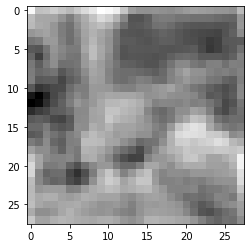

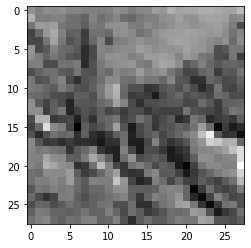

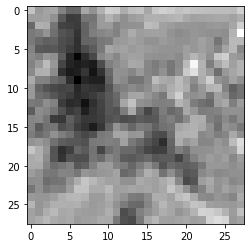

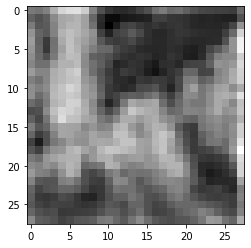

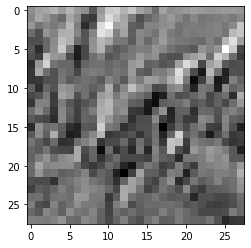

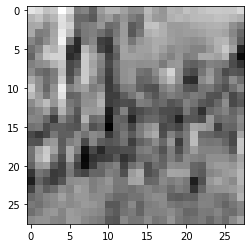

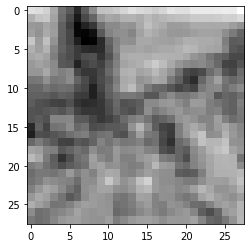

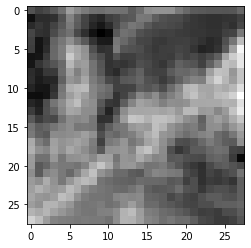

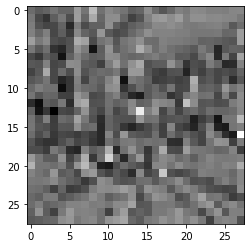

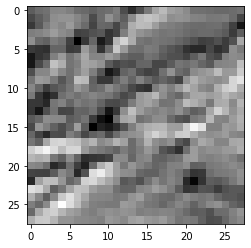

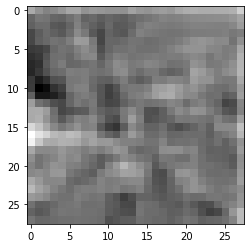

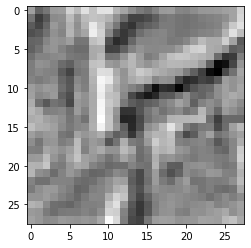

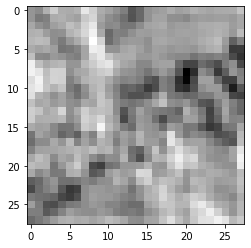

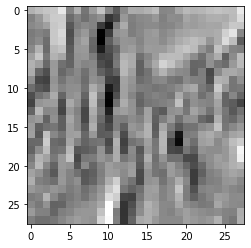

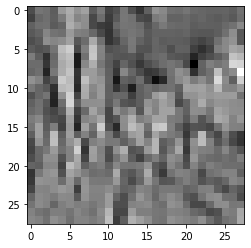

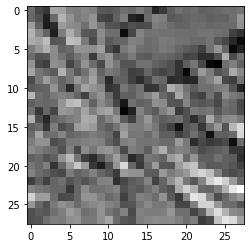

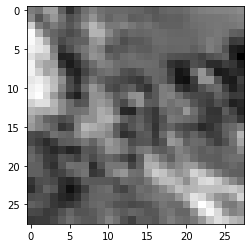

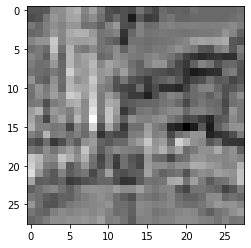

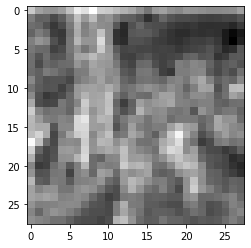

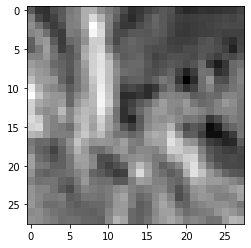

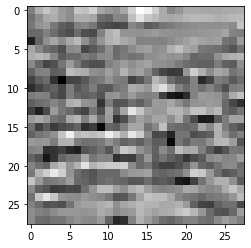

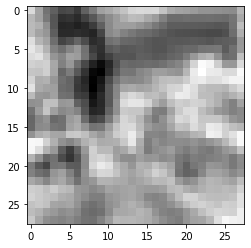

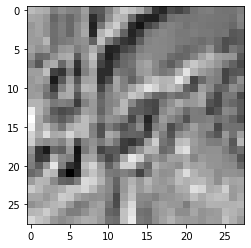

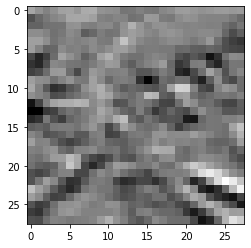

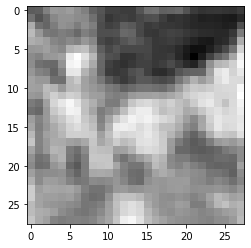

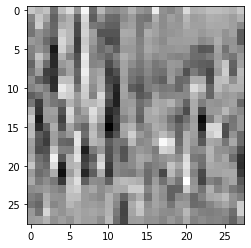

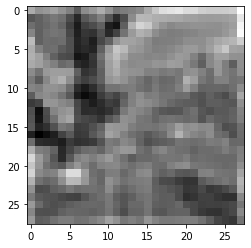

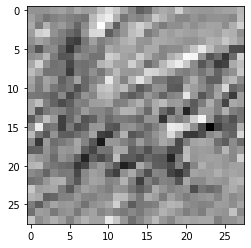

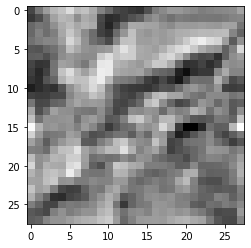

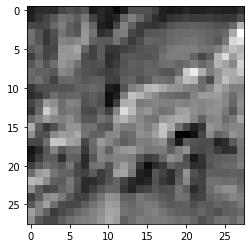

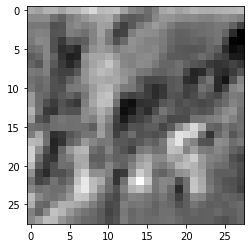

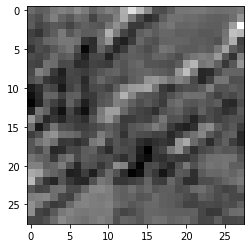

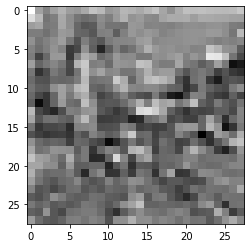

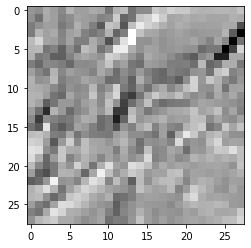

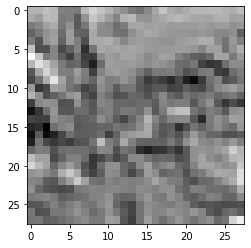

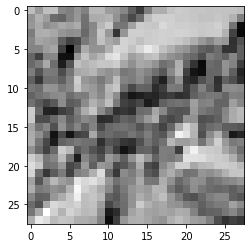

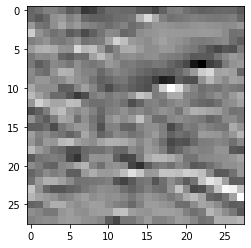

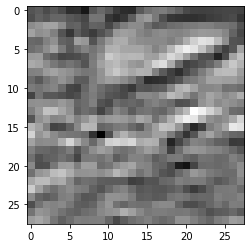

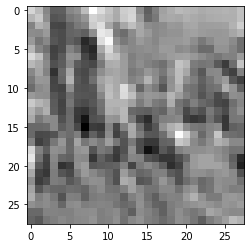

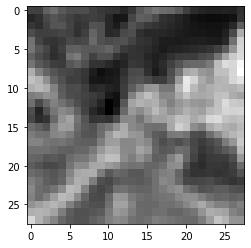

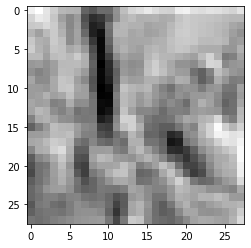

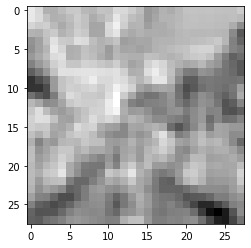

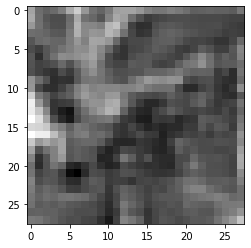

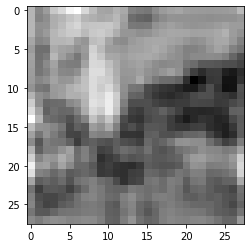

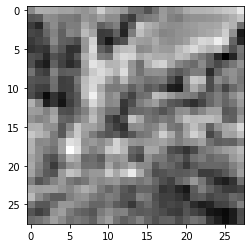

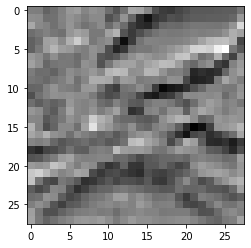

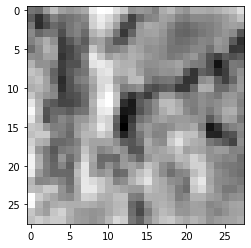

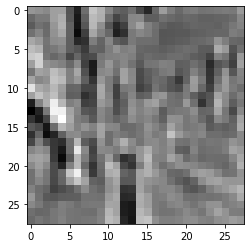

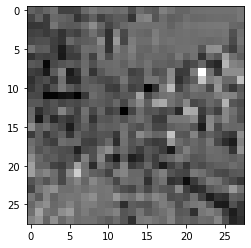

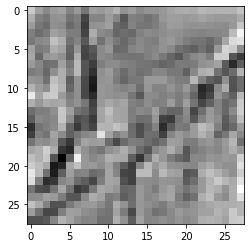

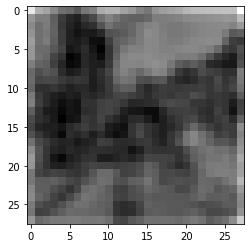

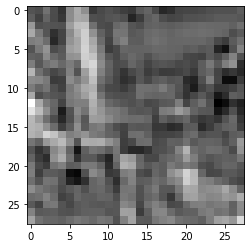

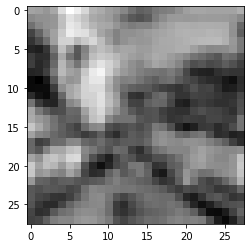

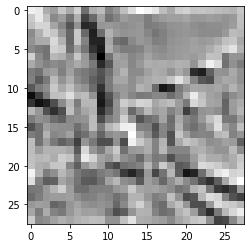

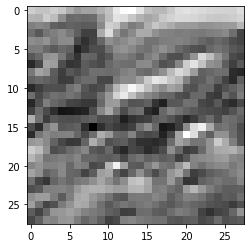

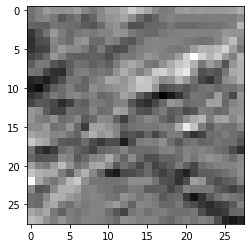

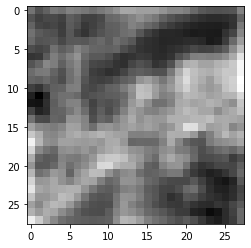

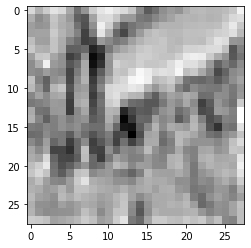

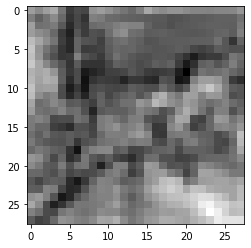

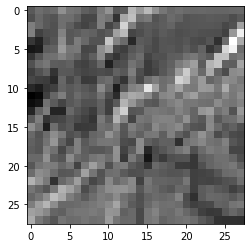

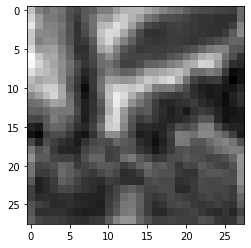

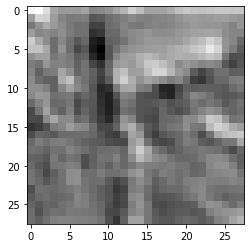

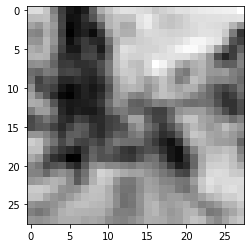

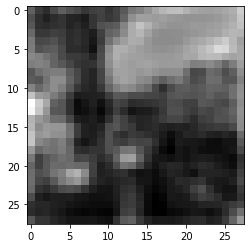

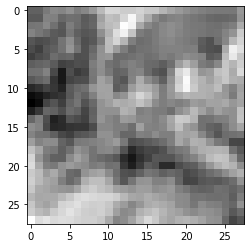

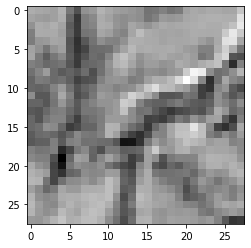

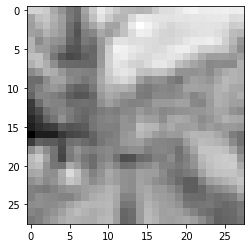

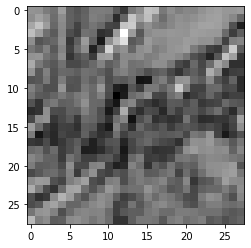

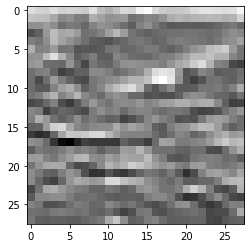

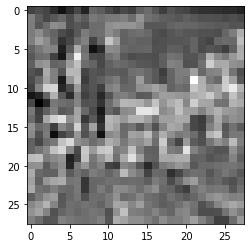

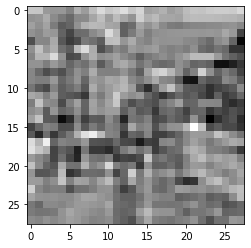

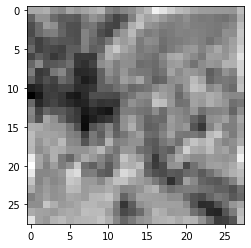

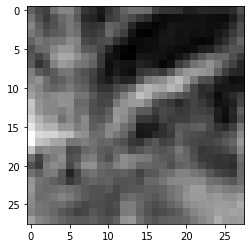

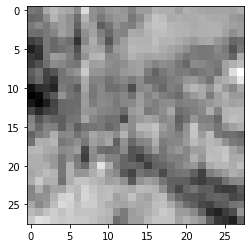

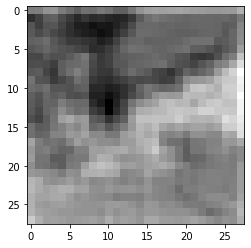

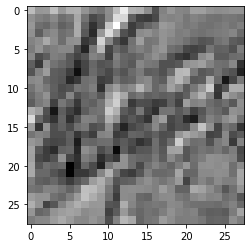

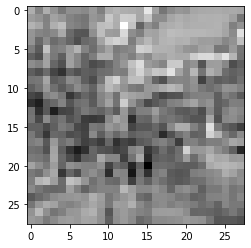

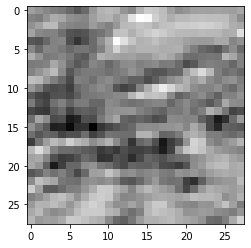

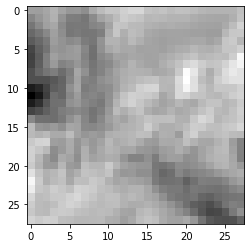

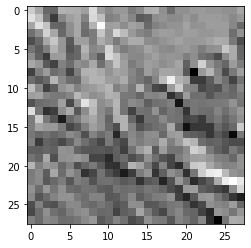

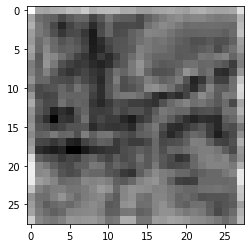

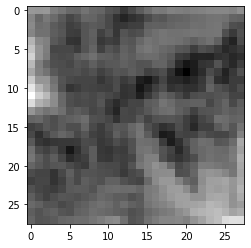

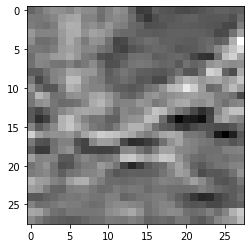

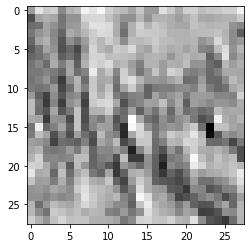

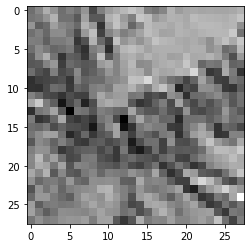

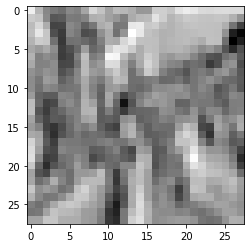

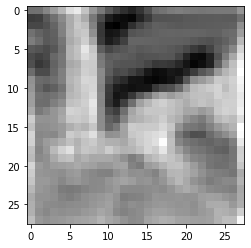

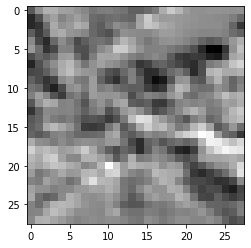

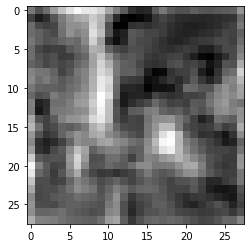

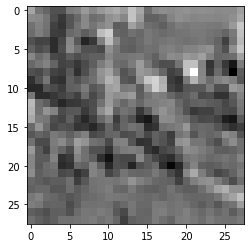

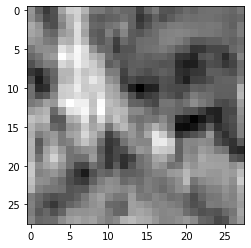

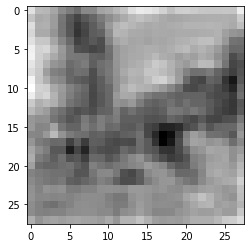

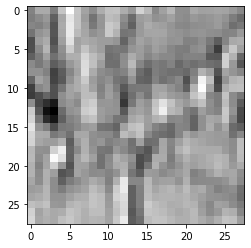

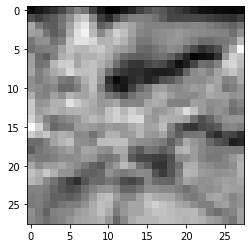

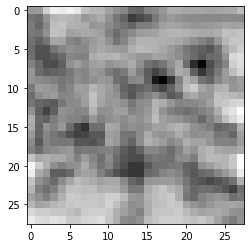

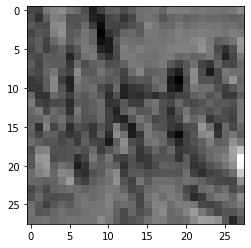

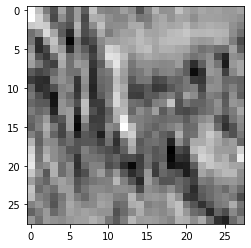

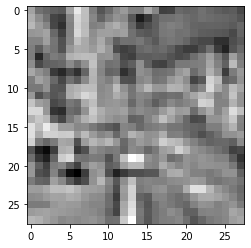

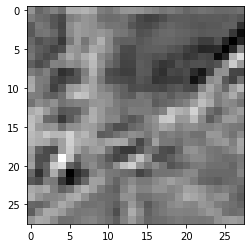

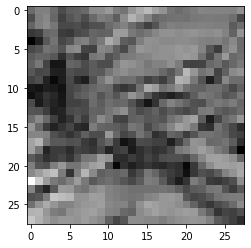

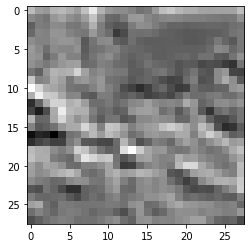

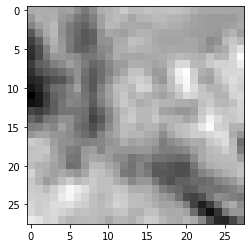

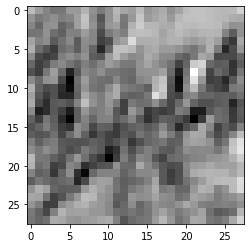

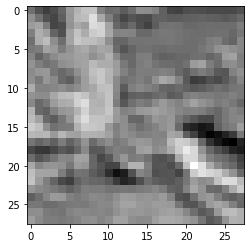

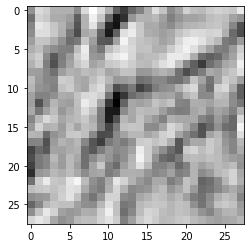

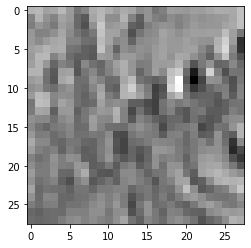

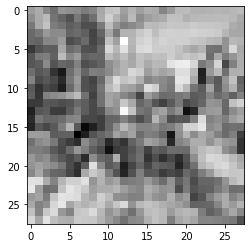

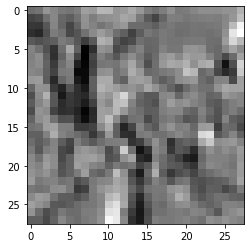

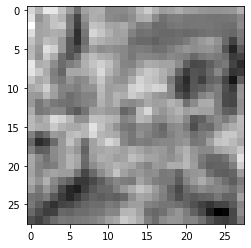

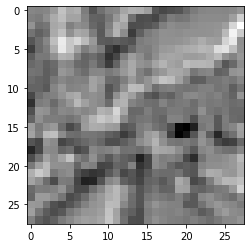

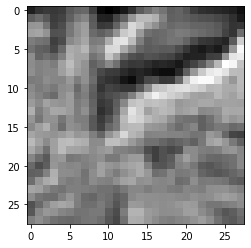

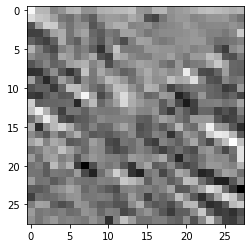

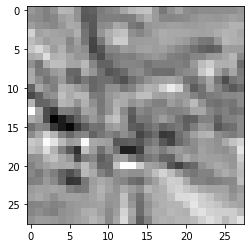

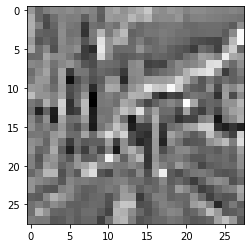

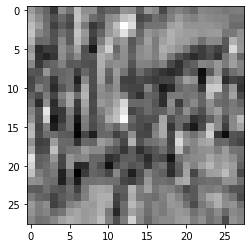

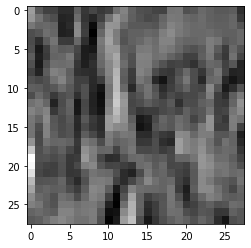

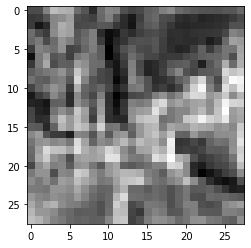

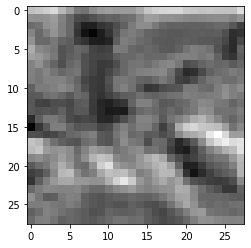

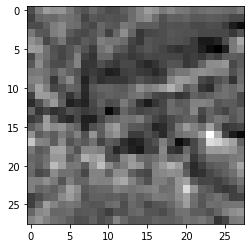

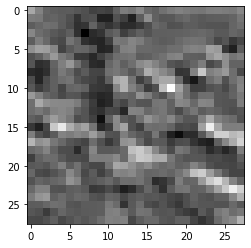

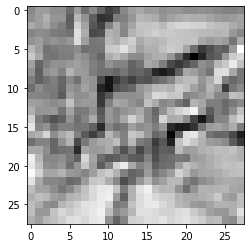

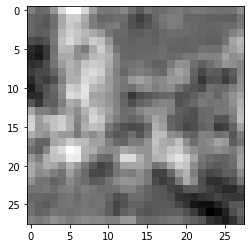

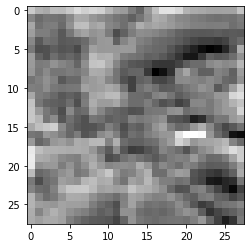

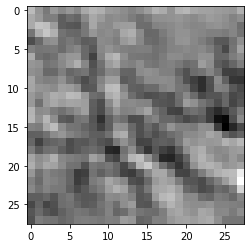

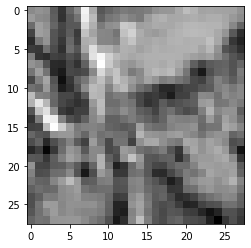

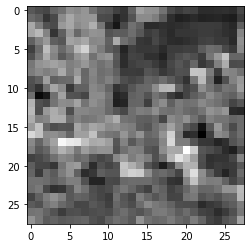

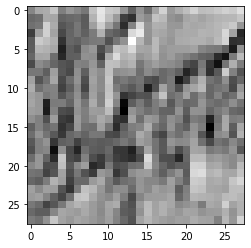

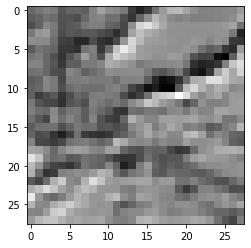

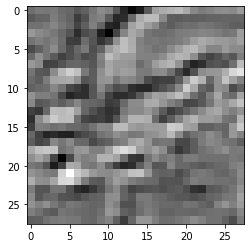

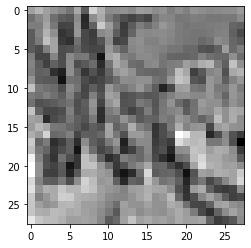

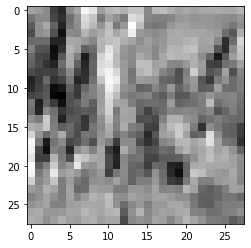

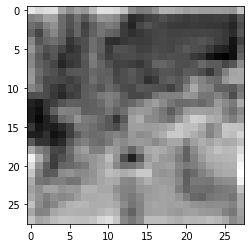

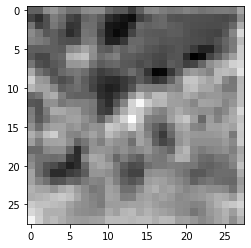

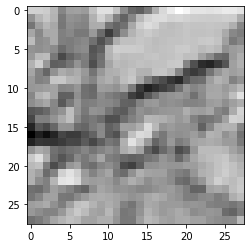

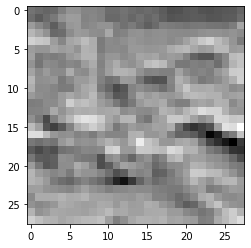

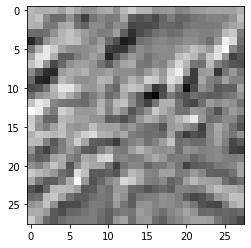

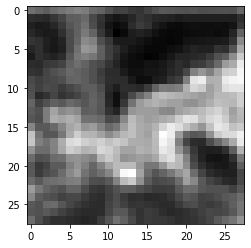

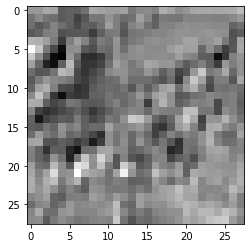

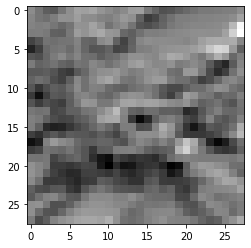

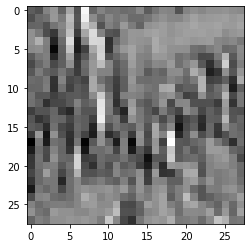

In [ ]:
for i in range(feature_maps_last.shape[3]):
  plt.imshow(feature_maps_last[0, :, :, i], 'gray')
  plt.show()

In [ ]:
feature_maps_last.shape

(1, 28, 28, 192)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

*italicized text*# Attempt at generalization

1/1 [==============================] - 0s 1ms/step


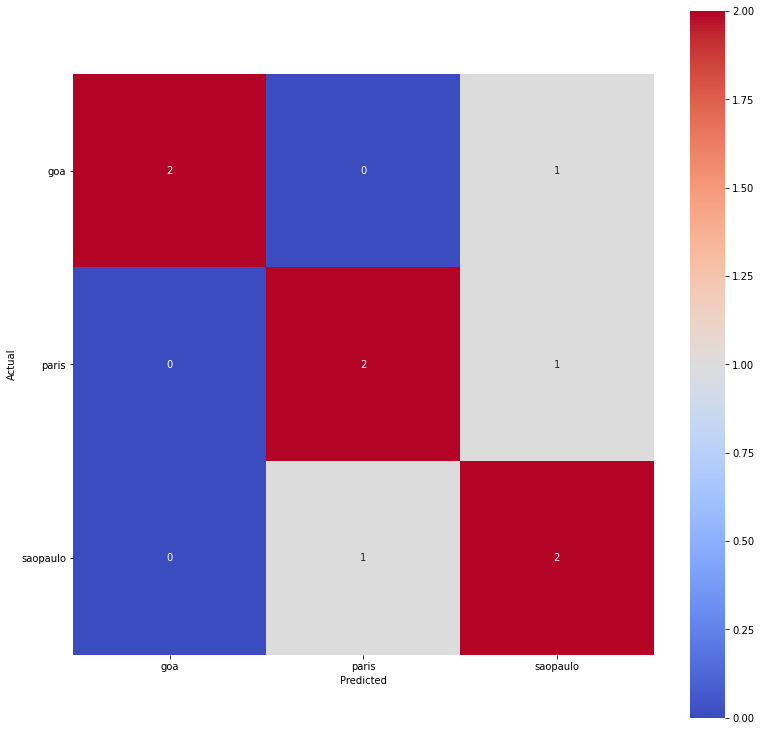

In [ ]:
# Setup generalization dataset (from drive)
gen_dir = Path(path_data+'/generalization/')
list_gen = tf.data.Dataset.list_files(str(gen_dir/"*/*"),shuffle=False)
labeled_gen = list_gen.map(process_path, num_parallel_calls=AUTOTUNE)
gen_dataset = prepare_for_training(labeled_gen)

# Get y_true and y_pred
X_true = np.array([l[0].numpy() for l in list(labeled_gen)])
Y_true = np.array([list(l[1].numpy()) for l in list(labeled_gen)])
y_true = np.argmax(Y_true,axis=1)
Y_pred = model.predict(np.array(X_true),verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, fmt='g',cmap = 'coolwarm',square=True,xticklabels=CLASS_NAMES,yticklabels=CLASS_NAMES)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

In [ ]:
def get_data(file_list,norm_range=[-1,1],img_size=(128,128)):
    X = []
    for filename in file_list :
        img = img_to_array(load_img(filename, target_size = img_size))
        X.append(img)
    X = np.array(X).astype('float32')
    if norm_range == [-1,1]:
      X = (X - X.mean()) / X.std()
      X = np.clip(X,-1,1)
    elif norm_range == [0,1]:
      X = X / 255
    else:
      print('bad range')
      return
    return X,X.mean(),X.std()

In [ ]:
paris_files = glob.glob('./train/paris/*')

In [ ]:
dataset,mean,std = get_data(paris_files)

In [ ]:
dataset.min(),dataset.max()

(-1.0, 1.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


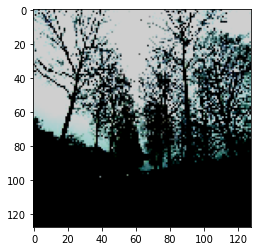

In [ ]:
# (X - X.mean()) / X.std()

im = dataset[2]

plt.imshow(im*im.std() + im.mean());
